# Lesson 3: Underfitting and Overfitting

This lesson will be a review of everything we've learned so far on CNNs. We'll also learn a few common practices in CNN architecture as well as how to avoid underfitting and overfitting a model.

## Layers in a CNN

### Convolutional Layers

We know convolutions are subsets of matrix products/weights. Given labeled inputs, we use SGD to optimize our weights to allow our network to learn which details best classify our images. We also know convolutions, like dense (or fully connected) layers, are linear and typically followed by an activation (or non-linear) layer. So, what differeniates convolutional layers from fully connected layers? 

Well, in the previous lesson, we learned that, in a fully connected layer, our weight matrices are mapped directly onto input vectors to get an output. Through optimization, the neural network learns what weights will get us closest to our desired output. In a convolutional layer, our weights aren't directly mapped over our inputs. Instead, nearby inputs are connected to nearby outputs through shared weights, or filters (a subset of the weights used in a fully connected layer). These filters act locally on the input image to identify details, like a top-edge, anywhere in the image, regardless of position--making convolutional filters **position invariant**.

#### Position Invariance and Zero Padding

Position invariance is an important characteristic for convolutional filters to have. With this, they are able to find patterns in an image regardless of where they are. Take face detection, as an example. To detect facial features, you want to be able to detect eyes wherever and however the face is positioned in an image. It's important to note the distance between both eyes compared to the nose, lips, etc. 

In order to have these convolutional filters pass over every pixel in our input image, we add **zero padding** to the input. To ensure your filter dimensions fit perfectly to scan (or map) the entire image input, you sometimes need to add a border of zeros (or extra black space) around the input so that the output dimensions of the filter are the same as the input shape. This is normally done after every convolution.

#### Filters

To get an even better understanding of how filters in a convolutional layer work, I read [A Beginner's Guide to Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/). Note: all images used in this section were taken from this post. Another note: obviously don't take the pixel values in this example seriously (i.e. a pixel value of 0 really gives the color black, not white). This was done for example purposes only, as you will see later.

We first start off with a curve detector filter, where we see the pixel representation (matrix on the left) of our filter (right). 

![img](https://i.imgur.com/AaytKLO.png[/img])

These filters are mapped over parts of our input image of similar dimensions. Our input image is of a mouse (left) and the area we'll overlay our curve detector filter is boxed on the right.

![img](http://i.imgur.com/Gqfrdnm.png[/img])

This is done through simple matrix multiplication of our filter with the highlighted subset of our input image (the mouse's backside). From left to right, we see the subset of our input along with it's pixel representation multiplied by the pixel representation of our filter. Note, both matrices share the same 7x7 dimension.

![img](http://i.imgur.com/4rl0Mmn.png[/img])

The resulting dot product is 6600 (obviously a very big number). Now let's map the same filter over another area of the image--this time near the mouse's ear.

![img](http://i.imgur.com/59OyMXg.png[/img])

The resulting dot product is 0 (which is why 0 was chosen specifically for this example). The message here is that the curve detector filter (convolved around the input image) only activated (or computed high values) when the feature was detected on the part of the input image where it correlated the most. The mouse's backside had a curve and was detected by the filter whereas the ears and top head of the mouse did not. 

This was a simplified version of how filters are used in CNNs. There are many layers of sophisticated filters, which is why we use finetuning. Pre-trained weights have already learned these filters and we simply finetune them for whatever classification task we attempt to do.

### Pooling Layers

These layers were briefly introduced in Lesson 1. Pooling Layers, like dense layers, are non-linear operations in CNNs used for reducing the dimensionality (or resolution) of images. These layers take in the output from the previous layer and return either their average or max values (a process called **max pooling**). This effectively decreases the overall size of the output layer, subsequently decreasing the computational and spacial complexity of the network.

As an example, let's use the MNIST data set, a collection of labeled 28x28 grey-scale images of handwritten digits. Each 28x28 image passes through a max pooling layer in 7x7 blocks, which are replaced by the max value of that block, resulting in a 4x4 image. Let's look at the 28x28 grey-scale image representation of the number 8:

![img](http://i.imgur.com/Y2zV5Qx.png[/img])

And it's resulting 4x4 image once passed through the max pooling layer in 7x7 pixel increments:

![img](http://i.imgur.com/4LpFEEZ.png[/img])

For a better explanation, you can follow the course's [Convolution Intro Notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/convolution-intro.ipynb). 

So, we see that pooling is, in a way, forcing our neural network to look at larger areas of our image at once. To bring it back to cats and dogs, instead of having our network identify fur or tails, we use max pooling to identify if the image contains either a cat or dog. But, what happens to the information that's lost? The information content at each layer is preserved by increasing the number of filters in subsequent convolutional layers. This is why our number of filters doubles every time we use max pooling. 

### Activation Layers

Here's an overview of everything we've discussed so far: neural networks are a collection of matrix products (generally, linear layers). Their subsets are convolutions stacked with nonlinear activation layers. Specifically, we looked at ReLU (```max(0,x)```) and softmax (```exp(x[i])/sum(exp(x))```) in [Lesson 2](https://github.com/fdaham/fastai/blob/master/lesson2.ipynb). Unlike ReLU, which is used in intermediate layers, softmax is generally used in the last layer. Here is the softmax function applied to an output $x$ that I created as an example:

In [6]:
import pandas as pd
pd.DataFrame({'x[i]':[2.45,-0.02,-3.19], 'exp(x[i])':[11.59,0.98,0.04], 'softmax(x[i])':[0.92,0.08,0.00]}, 
             columns=['x[i]','exp(x[i])','softmax(x[i])'])

,x[i],exp(x[i]),softmax(x[i])
0,2.45,11.59,0.92
1,-0.02,0.98,0.08
2,-3.19,0.04,0.00


The last layer of our network should be one hot encoded, like our expected output. Therefore, you want your output to be a probability where all values sum to 1. Notice in the table above that the first value is by far greater than the rest. This makes it easier to one hot encode our output, which would return ```[1 0 0]```.

So far, we've learned pretty much all the basics of a CNN. Now, let's look at some issues we might face when building a neural network, like underfitting and overfitting our model. Let's first import the libraries necessary for this notebook and complete some configuration steps:

In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [7]:
#path = "data/dogscats/sample/"
path = "data/dogscats/"
model_path = "data/models/"
if not os.path.exists(model_path): os.mkdir(model_path)

batch_size=64

## Underfitting and Overfitting

As seen in previous lessons, our validation accuracies have generally been greater than our training accuracies. This happens when our network experiences **dropout**, which randomly deletes (generally) half of the activation layers to avoid **overfitting** (or over training) our model. Setting random parts of our network to zero during training ensures that no part can overfit to another in the set. However, if overused, dropout could cause **underfitting**, which is when our model lacks the complexity of the problem we are trying to solve. Max pooling reduces the parameters and computations used in a network, consequently controlling overfitting. Overfitting only seems to be bad if it's done to the extent that your accuracy is also bad.

Now that we know dropout is what's keeping our validation accuracy greater than our training accuracy, do we want that? Not really. If our validation accuracy is higher than our training accuracy, it's normally a sign that we're underfitting our model. We can probably get better results with less dropout. So, let's try removing all dropout from our finetuned cats vs dogs model and see what happens.

### Reducing Underfitting by Removing Dropout

We start with our finetuned cats vs dogs model, where we first remove dropout from all the dense layers before finetuning them. Here, we'll use our model to predict our binary dependent and load our finetuned weights: 

In [4]:
model = vgg_ft(2)

In [8]:
model.load_weights(model_path+'finetune2.h5')

Next, we'll need to find all the fully connected (or ```Flatten```) layers in our model and create a new model with all the layers before the last fully connected layer (inclusive).

In [9]:
layers = model.layers

In [10]:
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

In [11]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
fc_layers = layers[last_conv_idx+1:]

We now apply the same steps used to create our linear model in Keras from Lesson 2 for our new fully connected model. Using the same architecture as the last layers of VGG 16, we can use pre-trained weights and remove dropout by setting $p = 0$. With a more finely-tuned model, we can lower the learning rate, ```lr```. 

In [12]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [14]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [15]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [16]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [17]:
# copy weights (half since we're removing dropout) from the pre-trained model.
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [18]:
opt = RMSprop(lr=0.00001, rho=0.7)

In [19]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
fc_model = get_fc_model()

Now, we fit the model and save the weights:

In [21]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 33s - loss: 0.2052 - acc: 0.9830 - val_loss: 0.2081 - val_acc: 0.9845
Epoch 2/8
23000/23000 [==============================] - 34s - loss: 0.1364 - acc: 0.9896 - val_loss: 0.2172 - val_acc: 0.9815
Epoch 3/8
23000/23000 [==============================] - 34s - loss: 0.1028 - acc: 0.9925 - val_loss: 0.2107 - val_acc: 0.9850
Epoch 4/8
23000/23000 [==============================] - 33s - loss: 0.0810 - acc: 0.9946 - val_loss: 0.1761 - val_acc: 0.9855
Epoch 5/8
23000/23000 [==============================] - 33s - loss: 0.0669 - acc: 0.9954 - val_loss: 0.1600 - val_acc: 0.9865
Epoch 6/8
23000/23000 [==============================] - 33s - loss: 0.0626 - acc: 0.9959 - val_loss: 0.1893 - val_acc: 0.9860
Epoch 7/8
23000/23000 [==============================] - 33s - loss: 0.0597 - acc: 0.9962 - val_loss: 0.1624 - val_acc: 0.9885
Epoch 8/8
23000/23000 [==============================] - 33s -

In [22]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [23]:
fc_model.load_weights(model_path+'no_dropout.h5')

We see that we overfit our model because the training accuracies are now greater than the validation accuracies. So, how can we reduce this?

### Reducing Overfitting

There are several ways to fix models that have been overtrained besides adding dropout or relying on other regularization techniques. To accomplish this, you can follow these steps:

1. Add more data
2. Augment data
3. Try different architectures
4. Add regularization
5. Reduce model complexity

In most cases, you'll be using all the data you have, so option 1 doesn't really apply. Option 2 introduces **data augmentation**, where each batch is altered or modified to some degree in order to generate additional data. 

#### Data Augmentation

For image recognition, data augmentation includes flipping, rotating, stretching, shearing, and/or changing colors of images. This method is used to distort images to create synthetic ones (because you could always use more data--refer to step 1), but not to the degree where the image becomes unrecognizable. You should always use data augmentation. The best plan of action is to experiment to see which types and how much of it is needed to better train your model. For example, a car is most commonly not flipped upside down in the real world, so augmentating an image of a car by flipping it vertically will not help. Instead, you can flip the image horizontally.

Keras simplifies this process by automating data augmentation. All you have to do is choose which type and the maximum amount you want to use. Below, we'll define a generator that includes data augmentation to see how the generator can alter a single image of a cat:

In [24]:
# dim_ordering='tf' uses tensorflow dimension ordering for display purposes
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

In [89]:
# choose how many images to create
img = np.expand_dims(ndimage.imread(path + 'test/unknown/2000.jpg'),0)
aug_iter = gen.flow(img)

In [90]:
# get 8 examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

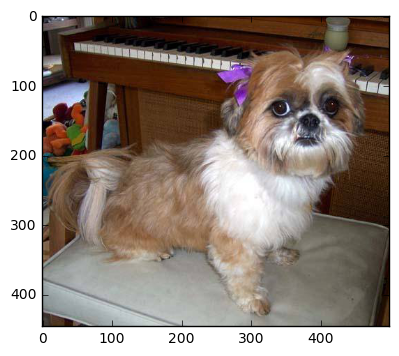

In [91]:
# show the original image
plt.imshow(img[0])

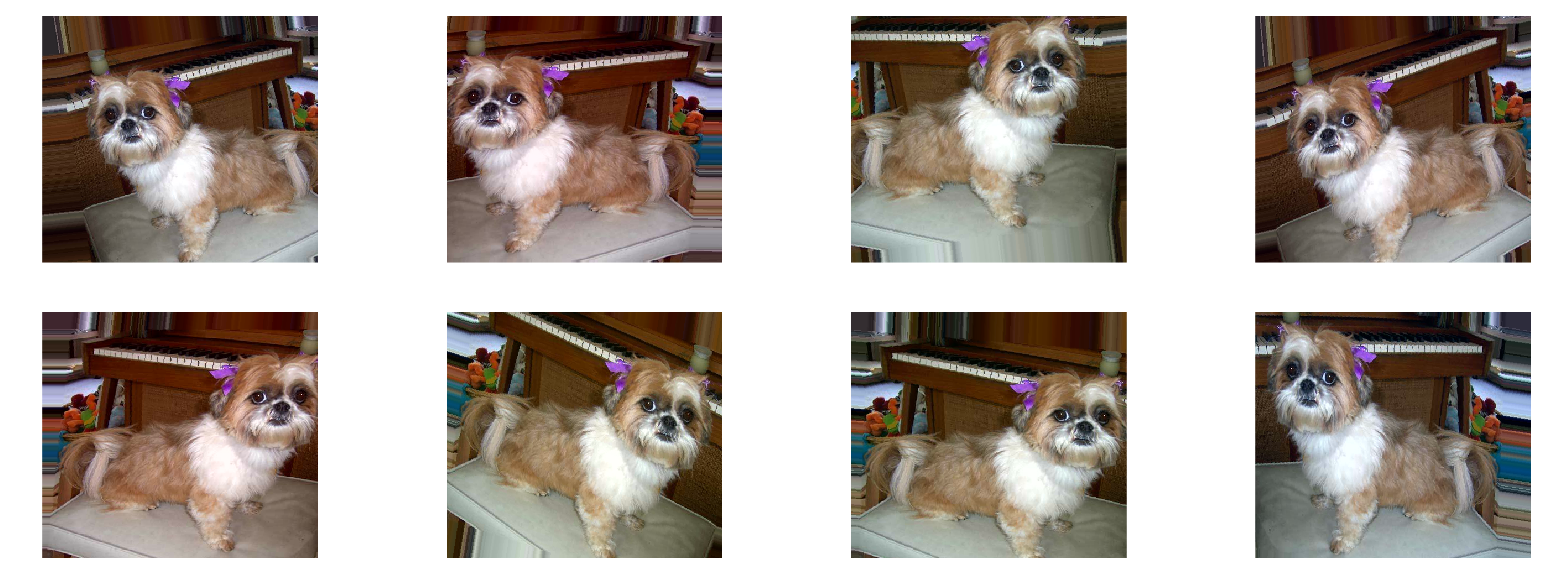

In [92]:
# show the 8 augmented images
plots(aug_imgs, (20,7), 2)

In [93]:
# return to theano dimension ordering
K.set_image_dim_ordering('th')

Now we can add data augmentation to our model to see if we can reduce overfitting. Just like we did in the example above, we will create a generator and add our batches to it:

In [94]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [95]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# don't augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


To allow data to pass through all the convolutional and fully connected layers, we attach our fully connected model to the convolutional model before compiling, training, and saving it. 

In [96]:
fc_model = get_fc_model()

In [97]:
for layer in conv_model.layers: layer.trainable = False
# connect two models
conv_model.add(fc_model)

In [98]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
23000/23000 [==============================] - 619s - loss: 0.2813 - acc: 0.9775 - val_loss: 0.2320 - val_acc: 0.9805
Epoch 2/8
23000/23000 [==============================] - 619s - loss: 0.2085 - acc: 0.9821 - val_loss: 0.2265 - val_acc: 0.9805
Epoch 3/8
23000/23000 [==============================] - 620s - loss: 0.1855 - acc: 0.9844 - val_loss: 0.1819 - val_acc: 0.9840
Epoch 4/8
23000/23000 [==============================] - 620s - loss: 0.1371 - acc: 0.9862 - val_loss: 0.1960 - val_acc: 0.9840
Epoch 5/8
23000/23000 [==============================] - 621s - loss: 0.1165 - acc: 0.9886 - val_loss: 0.1708 - val_acc: 0.9850
Epoch 6/8
23000/23000 [==============================] - 621s - loss: 0.0884 - acc: 0.9903 - val_loss: 0.1612 - val_acc: 0.9855
Epoch 7/8
23000/23000 [==============================] - 620s - loss: 0.0741 - acc: 0.9914 - val_loss: 0.1433 - val_acc: 0.9880
Epoch 8/8
23000/23000 [==============================] - 621s - loss: 0.0628 - acc: 0.9918 - val_loss: 0

In [100]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
23000/23000 [==============================] - 621s - loss: 0.0536 - acc: 0.9937 - val_loss: 0.1482 - val_acc: 0.9870
Epoch 2/3
23000/23000 [==============================] - 621s - loss: 0.0552 - acc: 0.9938 - val_loss: 0.1474 - val_acc: 0.9885
Epoch 3/3
23000/23000 [==============================] - 621s - loss: 0.0468 - acc: 0.9945 - val_loss: 0.1530 - val_acc: 0.9880


In [103]:
conv_model.save_weights(model_path + 'aug1.h5')

In [104]:
conv_model.load_weights(model_path + 'aug1.h5')

We now see that our training accuracies have lowered, so augmenting the data indeed helped with overfitting. Another approach to further lessen the training accuracy is through **batch normalization** (option 4).

#### Batch Normalization

Inputs to a neural network must always be normalized--a process where each element in a data set is subtracted by the mean and divided by the standard deviation. This is done to scale all inputs to a matter of how much they deviate from the mean because unbalanced inputs with a large range of magnitudes can typically cause instability in neural networks. In this way, batch normalization improves the training speed of our model and reduces the effect outliers have on our data set. For images, however, we don't usually need to divide by the standard deviation. 

Batch normalization (1) normalizes the intermediate layers of our model, (2) adds two trainable parameters at each layer (one to set an arbitrary standard deviation and the other to set an arbitrary mean), and (3) adds the normalized and learned parameters to the gradient calculations done in the back propagation. We can add batch normalization layers to our model the same way we added dropout layers:

In [106]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
        ]

In [107]:
def load_fc_weights_from_vgg16bn(model):
    # load weights for model from the dense layers of the Vgg16 model.
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [108]:
p=0.6

In [109]:
bn_model = Sequential(get_bn_layers(0.6))

In [110]:
load_fc_weights_from_vgg16bn(bn_model)

553426944/553620808 [============================>.] - ETA: 0s

In [111]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

In [112]:
for l in bn_model.layers: 
    if type(l)==Dense: l.set_weights(proc_wgts(l, 0.5, 0.6))

In [113]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable=False

In [114]:
bn_model.add(Dense(2,activation='softmax'))

In [115]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [116]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 12s - loss: 0.2986 - acc: 0.9493 - val_loss: 0.1362 - val_acc: 0.9815
Epoch 2/8
23000/23000 [==============================] - 12s - loss: 0.2951 - acc: 0.9595 - val_loss: 0.1470 - val_acc: 0.9800
Epoch 3/8
23000/23000 [==============================] - 12s - loss: 0.3362 - acc: 0.9619 - val_loss: 0.1534 - val_acc: 0.9835
Epoch 4/8
23000/23000 [==============================] - 12s - loss: 0.3433 - acc: 0.9630 - val_loss: 0.1746 - val_acc: 0.9810
Epoch 5/8
23000/23000 [==============================] - 12s - loss: 0.3553 - acc: 0.9637 - val_loss: 0.1600 - val_acc: 0.9810
Epoch 6/8
23000/23000 [==============================] - 12s - loss: 0.3681 - acc: 0.9627 - val_loss: 0.2182 - val_acc: 0.9790
Epoch 7/8
23000/23000 [==============================] - 12s - loss: 0.3663 - acc: 0.9646 - val_loss: 0.1860 - val_acc: 0.9820
Epoch 8/8
23000/23000 [==============================] - 12s -

In [117]:
bn_model.save_weights(model_path+'bn.h5')

In [118]:
bn_model.load_weights(model_path+'bn.h5')

In [119]:
bn_layers = get_bn_layers(0.6)
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

In [120]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: final_model.add(layer)

In [121]:
for l1,l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [122]:
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 628s - loss: 1.0098 - acc: 0.9331 - val_loss: 1.1183 - val_acc: 0.9275


In [124]:
final_model.save_weights(model_path + 'final1.h5')

In [125]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
23000/23000 [==============================] - 633s - loss: 0.7901 - acc: 0.9482 - val_loss: 0.5017 - val_acc: 0.9665
Epoch 2/4
23000/23000 [==============================] - 633s - loss: 0.6701 - acc: 0.9560 - val_loss: 0.5523 - val_acc: 0.9625
Epoch 3/4
23000/23000 [==============================] - 632s - loss: 0.6183 - acc: 0.9599 - val_loss: 0.4564 - val_acc: 0.9710
Epoch 4/4
23000/23000 [==============================] - 631s - loss: 0.5795 - acc: 0.9628 - val_loss: 0.4091 - val_acc: 0.9740


In [126]:
final_model.save_weights(model_path + 'final2.h5')

In [131]:
final_model.optimizer.lr=0.001

In [132]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
23000/23000 [==============================] - 631s - loss: 0.5229 - acc: 0.9660 - val_loss: 0.4777 - val_acc: 0.9695
Epoch 2/4
23000/23000 [==============================] - 632s - loss: 0.4896 - acc: 0.9683 - val_loss: 0.4145 - val_acc: 0.9735
Epoch 3/4
23000/23000 [==============================] - 631s - loss: 0.5387 - acc: 0.9650 - val_loss: 0.4047 - val_acc: 0.9730
Epoch 4/4
23000/23000 [==============================] - 630s - loss: 0.5139 - acc: 0.9667 - val_loss: 0.4423 - val_acc: 0.9725


In [134]:
bn_model.save_weights(model_path + 'final3.h5')

We now see that our validation accuracies are greater than our training accuracies, so our model is no longer overfit. 